In [47]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

from sklearn.metrics import mean_absolute_error

In [48]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('https://raw.githubusercontent.com/minknhom/dataset/main/FB.csv')
# df = pd.read_csv('https://raw.githubusercontent.com/huy164/datasets/master/walmart_stock_price.csv')

df['Date'] = pd.to_datetime(df['Date'])

start_date = '2020-01-01'
end_date = '2022-12-31'
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

df1=df.reset_index()['Close']

In [49]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [50]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [51]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [52]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [53]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [54]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [55]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
5/5 [==============================] - 3s 183ms/step - loss: 0.2704 - val_loss: 0.1444
Epoch 2/100
5/5 [==============================] - 0s 76ms/step - loss: 0.0973 - val_loss: 0.0354
Epoch 3/100
5/5 [==============================] - 0s 68ms/step - loss: 0.0140 - val_loss: 0.0188
Epoch 4/100
5/5 [==============================] - 0s 73ms/step - loss: 0.0134 - val_loss: 0.0402
Epoch 5/100
5/5 [==============================] - 0s 71ms/step - loss: 0.0199 - val_loss: 0.0259
Epoch 6/100
5/5 [==============================] - 0s 67ms/step - loss: 0.0074 - val_loss: 0.0144
Epoch 7/100
5/5 [==============================] - 0s 72ms/step - loss: 0.0038 - val_loss: 0.0136
Epoch 8/100
5/5 [==============================] - 0s 72ms/step - loss: 0.0058 - val_loss: 0.0139
Epoch 9/100
5/5 [==============================] - 0s 67ms/step - loss: 0.0055 - val_loss: 0.0128
Epoch 10/100
5/5 [==============================] - 0s 74ms/step - loss: 0.0039 - val_loss: 0.0127
Epoch 11/100
5/5 [

In [56]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

3/3 [==============================] - 0s 12ms/step


In [57]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [58]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE & MAPE
rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', rmse)

mape = mean_absolute_error(ytest, y_pred) / sum(ytest) * 100
print('Testing MAPE:', mape, '%')

# Calculate MAE
mae = mean_absolute_error(ytest, y_pred)
print("Testing MAE:", mae)

Testing RMSE: 279.5785278422192
Testing MAPE: 787.0535196880055 %
Testing MAE: 273.4705378899056


In [60]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=107
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.82470257 0.82936026 0.75623488 0.77351064 0.71897364 0.70377274
 0.72367371 0.75183137 0.77897285 0.77092769 0.78591693 0.8038278
 0.82618458 0.8155566  0.80179532 0.76906475 0.76948807 0.8251684
 0.8534107  0.83393317 0.82466018 0.81585302 0.84384128 0.82567649
 0.80975571 0.82588815 0.79226829 0.81305841 0.75559977 0.69691329
 0.69602414 0.68099252 0.72769616 0.74861331 0.78142865 0.77829535
 0.77799893 0.79806917 0.79489349 0.82842872 0.79980523 0.79510529
 0.75979175 0.79684134 0.78096294 0.80124485 0.84756743 0.84773683
 0.83384854 0.83986108 0.80594492 0.81521792 0.80670706 0.75437193
 0.78947367 0.78663681 0.77088544 0.79756109 0.79286114 0.76415301
 0.78710251 0.72888174 0.73497905 0.72214932 0.66545293 0.68891052
 0.65266545 0.62929251 0.62933489 0.65927085 0.70817638 0.73248087
 0.74941782 0.38849134 0.38565441 0.33408142 0.31405343 0.36410215
 0.34746163 0.3113859  0.30355254 0.31752554 0.2986408  0.26125254
 0.25468946 0.23741376 0.22204345 0.26078677 0.27298

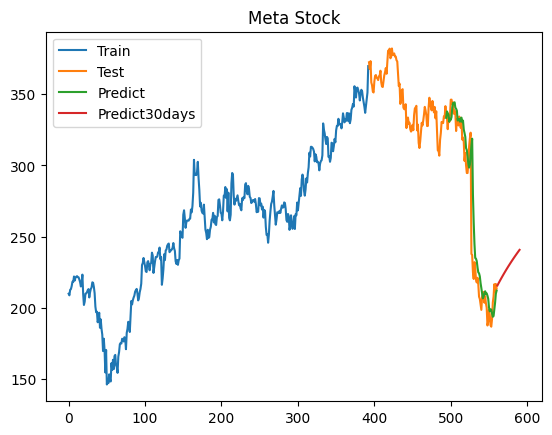

In [61]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.title('Meta Stock')
plt.legend(['Train','Test','Predict', 'Predict30days'])
plt.show()